In [2]:
# import libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
# data
game_stats = pd.read_csv("regular_season_totals_2010_2024.csv")
game_stats.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG
0,2022-23,1610612744,GSW,Golden State Warriors,22201230,2023-04-09T00:00:00,GSW @ POR,W,48.0,58,...,1,1578,55,512,457,678,2455,3,1,1.0
1,2020-21,1610612749,MIL,Milwaukee Bucks,22000051,2020-12-29T00:00:00,MIL @ MIA,W,48.0,51,...,146,1636,33,1830,1361,1552,1220,14,7,1.0
2,2013-14,1610612751,BKN,Brooklyn Nets,21300359,2013-12-16T00:00:00,BKN vs. PHI,W,48.0,47,...,22,2280,406,1979,1,1004,453,19,12,1.0
3,2013-14,1610612757,POR,Portland Trail Blazers,21300347,2013-12-14T00:00:00,POR @ PHI,W,48.0,52,...,2,2065,628,204,1269,272,2190,4,15,1.0
4,2018-19,1610612745,HOU,Houston Rockets,21801200,2019-04-07T00:00:00,HOU vs. PHX,W,48.0,53,...,84,176,149,917,1,244,1725,4,20,1.0


#### Question 1: From 2010 to 2024, what is the average number of 4-in-6 stretches for a team in a season?

In [5]:
# function to count how many 4-in-6 stretches there are in a season schedule
def four_in_six(schedule):
    # first and last game date from dataset
    current_date = schedule['GAME_DATE'].iloc[0]  # first game
    last_date = schedule['GAME_DATE'].iloc[-1]    # last game
    
    # counter for 4th game played over the past 6 nights
    games = 0
    
    # loop through schedule dates
    while current_date <= last_date:
        # 6 night stretch
        new_date = current_date + dt.timedelta(days=5)
        mask = (schedule['GAME_DATE'] >= current_date) & (schedule['GAME_DATE'] <= new_date)
        if mask.sum() == 4:
            games += 1
        current_date = current_date + dt.timedelta(days=1)
    return games

   season  4_in_6_stretches_total
0    2010                    31.0
1    2011                    40.7
2    2012                    30.9
3    2013                    30.4
4    2014                    31.9
5    2015                    28.9
6    2016                    28.6
7    2017                    20.4
8    2018                    19.5
9    2019                    17.7
10   2020                    30.0
11   2021                    24.1
12   2022                    23.9
13   2023                    23.5
27.2


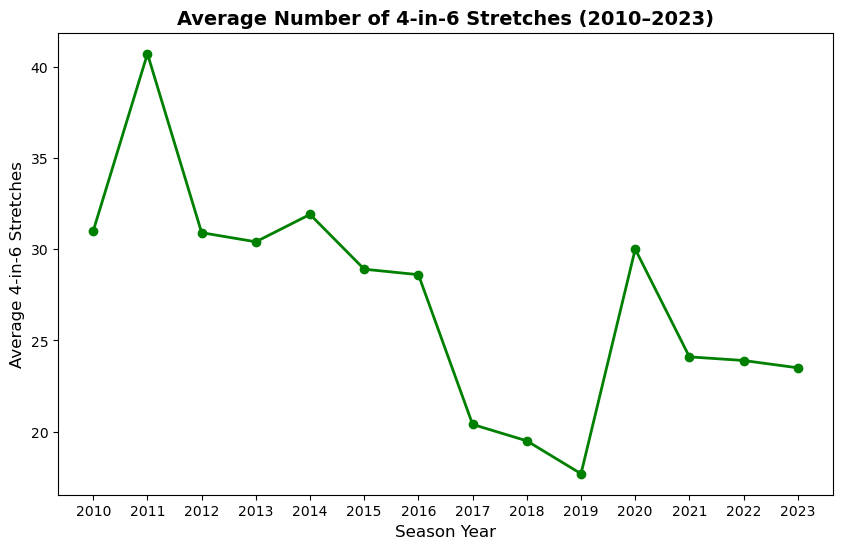

In [6]:
# clean original dataset to extract schedule for all seasons/teams
game_stats['SEASON_YEAR']=game_stats['SEASON_YEAR'].str.split("-").str[0]
schedule_10_24 = game_stats[['SEASON_YEAR', 'GAME_DATE', 'TEAM_ABBREVIATION', 'MATCHUP', 'WL']].sort_values(['SEASON_YEAR', 'GAME_DATE']).copy()
schedule_10_24['GAME_DATE'] = pd.to_datetime(schedule_10_24['GAME_DATE']).dt.date

# group data by its season and team
team = schedule_10_24.groupby(['SEASON_YEAR', 'TEAM_ABBREVIATION'])

# empty list to store results for each team and its respective season
stretches = []

# loop through each team schedule for 2010-11 to 2023-24 seasons
for i in team:
    current_schedule = i[1].sort_values(['GAME_DATE'])  # team schedule for a season
    #current_schedule['GAME_DATE'] = pd.to_datetime(current_schedule['GAME_DATE']).dt.date
    #print(current_schedule.head(5))
    #season_year = current_schedule['gamedate'].dt.year
    #print(season_year)

    result = four_in_six(current_schedule)
    stretches.append([current_schedule['SEASON_YEAR'].iloc[0], current_schedule['TEAM_ABBREVIATION'].iloc[0], result])
    
# create dataframe from results for easy calculations
df_stretches = pd.DataFrame(stretches, columns=['season', 'team', '4_in_6_stretches_total'])
season_avg = df_stretches.groupby('season')['4_in_6_stretches_total'].mean().round(1).reset_index()
total_avg = (season_avg['4_in_6_stretches_total'].mean().round(1))
print(season_avg)
print(total_avg)

# visualization
plt.figure(figsize=(10,6))
plt.plot(season_avg['season'], season_avg['4_in_6_stretches_total'], marker='o', linewidth=2, color='green')
plt.xlabel("Season Year", fontsize=12)
plt.ylabel("Average 4-in-6 Stretches", fontsize=12)
plt.title("Average Number of 4-in-6 Stretches (2010–2023)", fontsize=14, weight='bold')
plt.show()




27.2 4-in-6 stretches on average from 2010-11 to 2023-24. We can see that the NBA has started to decrease the number of 4-in-6 stretches in recent seasons. There was a peak during the 2020 season due to COVID-19 where the regular season was reduced from its standard 82 games to 72 games.

#### Question 2: How does a team’s likelihood of winning change when playing on the second night of a back-to-back?

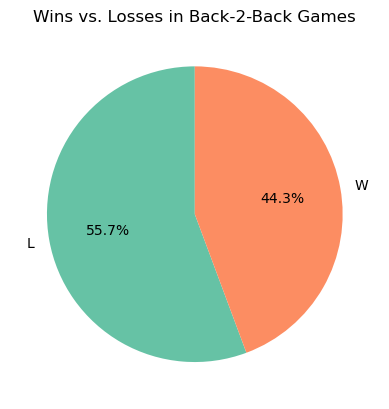

In [7]:
# Column for previous date of current game day
schedule_10_24['previous_date'] = schedule_10_24['GAME_DATE'] - pd.Timedelta(days=1)

# Temporary game date schedule
temp_schedule = schedule_10_24[['TEAM_ABBREVIATION', 'GAME_DATE']].copy()

# Merge schedules to get b2b games
merged_schedule = schedule_10_24.merge(
    temp_schedule,
    left_on=['TEAM_ABBREVIATION', 'previous_date'],
    right_on=['TEAM_ABBREVIATION', 'GAME_DATE'],
    how = 'left'
)

# Filter merged df for only games that are the 2nd night of b2b
b2b_games = merged_schedule[merged_schedule['GAME_DATE_y'].notnull()]

# Count wins vs losses for b2b games
wl_counts = b2b_games.groupby('WL')['WL'].count()
game_wins = round((wl_counts['W'])/(len(b2b_games['WL'])) * 100,2)
game_losses = round((wl_counts['L'])/(len(b2b_games['WL'])) * 100,2)

# Pie chart
plt.pie(
    wl_counts,
    labels=wl_counts.index,   
    autopct='%.1f%%',
    startangle=90,
    colors=sns.color_palette('Set2')
)
plt.title("Wins vs. Losses in Back-2-Back Games")
plt.show()

#### Question 3: Probability of winning at home vs. away games

In [9]:
# create dataframe copy of only home games
home_df = schedule_10_24[schedule_10_24['MATCHUP'].str.contains('vs.')].copy()

# home wins
home_wins = home_df.groupby('WL').get_group('W')['WL'].count()
home_loss = home_df.groupby('WL').get_group('L')['WL'].count()
win_prob = round(home_wins / (home_wins + home_loss) * 100,2)
loss_prob = round(home_loss / (home_wins + home_loss) * 100,2)

print(f"The probability of a team winning a game at home is \033[1m{win_prob:.2f}%\033[0m.")
print(f"The probability of a team losing a game at home is \033[1m{loss_prob:.2f}%\033[0m.")

The probability of a team winning a game at home is 57.64%.
The probability of a team losing a game at home is 42.36%.
